# Predicting 30-Day Hospital Readmission Risk with MIMIC-III
# A Tutorial for Healthcare Machine Learning

This Jupyter Notebook demonstrates how to predict whether a patient will be readmitted to the hospital within 30 days using the MIMIC-III dataset. We'll use Python, pandas, and scikit-learn to preprocess the data, train a machine learning model, and evaluate its performance.

### Objectives
1. Load and preprocess MIMIC-III data.
2. Engineer features relevant to readmission risk.
3. Train a Random Forest and XGBoost model for binary classification.
4. Evaluate and visualize the results.

### Prerequisites
- MIMIC-III dataset (CSV files or database access).
- Python libraries: pandas, numpy, scikit-learn, matplotlib, seaborn.

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
pd.set_option('display.max_rows', None)

# Set random seed for reproducibility
np.random.seed(42)

# Load all required data files: DEMO data
patients = pd.read_csv("C:\\Users\\.......\\projects\\AI4H_UT\\full_dataset\\PATIENTS.csv")
admissions = pd.read_csv("C:\\Users\\.......\\projects\\AI4H_UT\\full_dataset\\ADMISSIONS.csv")
diagnoses_icd = pd.read_csv("C:\\Users\\.......\\projects\\AI4H_UT\\full_dataset\\DIAGNOSES_ICD.csv")

## Step 1: Load and Explore the Data
We'll load the MIMIC-III data from CSV files and explore key tables: ADMISSIONS (hospital stays), PATIENTS (demographics), and DIAGNOSES_ICD (diagnoses).

In [2]:
# Display basic info
print("Admissions Shape:", admissions.shape)
print(admissions.head())
print("\nPatients Shape:", patients.shape)
print(patients.head())
print("\nDiagnoses Shape:", diagnoses_icd.shape)
print(diagnoses_icd.head())

Admissions Shape: (58976, 19)
   ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  

## Step 2: Preprocess the Data
We need to:
- Merge tables to get patient info and diagnoses per admission.
- Identify readmissions within 30 days.
- Handle missing data and create a clean dataset.

In [3]:
# Convert date columns to datetime
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

# Sort admissions by subject_id and admission time
admissions = admissions.sort_values(['SUBJECT_ID', 'ADMITTIME'])

# Calculate time difference between consecutive admissions for each patient
admissions['PREV_DISCHTIME'] = admissions.groupby('SUBJECT_ID')['DISCHTIME'].shift(1)
admissions['DAYS_TO_NEXT_ADMIT'] = (admissions['ADMITTIME'] - admissions['PREV_DISCHTIME']).dt.days

# Label readmissions within 30 days (1 = readmitted, 0 = not readmitted)
admissions['READMISSION_30'] = np.where(admissions['DAYS_TO_NEXT_ADMIT'] <= 30, 1, 0)
admissions['READMISSION_30'] = admissions['READMISSION_30'].fillna(0)

# Merge with patient data (e.g., age, gender)
patients['DOB'] = pd.to_datetime(patients['DOB'])
admissions = admissions.merge(patients[['SUBJECT_ID', 'DOB', 'GENDER']], on='SUBJECT_ID', how='left')

admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME']).dt.date

admissions['DOB'] = pd.to_datetime(admissions['DOB']).dt.date

# admissions['AGE'] = (admissions['ADMITTIME'] - admissions['DOB']).dt.days // 365

admissions['AGE'] = ((admissions['ADMITTIME']-admissions['DOB']) //365).dt.days

# Merge with diagnoses (count number of diagnoses per admission)
diag_count = diagnoses_icd.groupby('HADM_ID').size().reset_index(name='DIAG_COUNT')
admissions = admissions.merge(diag_count, on='HADM_ID', how='left')
admissions['DIAG_COUNT'] = admissions['DIAG_COUNT'].fillna(0)

# Select relevant columns and drop rows with missing critical data
features = ['SUBJECT_ID', 'HADM_ID', 'AGE', 'GENDER', 'DIAG_COUNT', 'READMISSION_30']
data = admissions[features].dropna(subset=['AGE'])

# Encode categorical variables (e.g., GENDER)
data['GENDER'] = data['GENDER'].map({'M': 1, 'F': 0})

print("Preprocessed Data Shape:", data.shape)
print(data.head())

Preprocessed Data Shape: (58976, 6)
   SUBJECT_ID  HADM_ID  AGE  GENDER  DIAG_COUNT  READMISSION_30
0           2   163353    0       1           3               0
1           3   145834   76       1           9               0
2           4   185777   47       0           9               0
3           5   178980    0       1           3               0
4           6   107064   65       0           8               0


([<matplotlib.patches.Wedge at 0x22a71fd9ca0>,
 [Text(-1.081379824447089, 0.2015382724913141, '0'),
  Text(1.0813798291644323, -0.2015382471797929, '1')],
 [Text(-0.589843540607503, 0.10992996681344404, '94.1%\n(55517)'),
  Text(0.5898435431805994, -0.10992995300715976, '5.9%\n(3459)')])

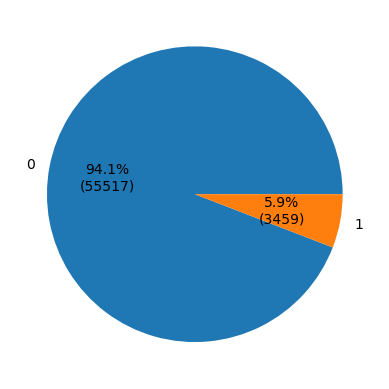

In [4]:
# Check class balance
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

s = data['READMISSION_30'].value_counts()
plt.pie(s,labels = s.index, autopct=autopct_format(s))

## Step 3: Feature Engineering and Train-Test Split
We'll use AGE, GENDER, and DIAG_COUNT as features to predict READMISSION_30. Then split the data into training and testing sets.

In [5]:
# Define features and target
X = data[['AGE', 'GENDER', 'DIAG_COUNT']]
y = data['READMISSION_30']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (47180, 3)
Testing Set Shape: (11796, 3)


## Step 4: Train a Random Forest Model
We'll use a Random Forest Classifier, a robust ML model that handles tabular data well.

In [6]:
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of readmission

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc)

AUC Score: 0.5512211367788444


## Step 5: Evaluate and Visualize Results from Random Forest
We'll evaluate the model with a confusion matrix and ROC curve to understand its performance.

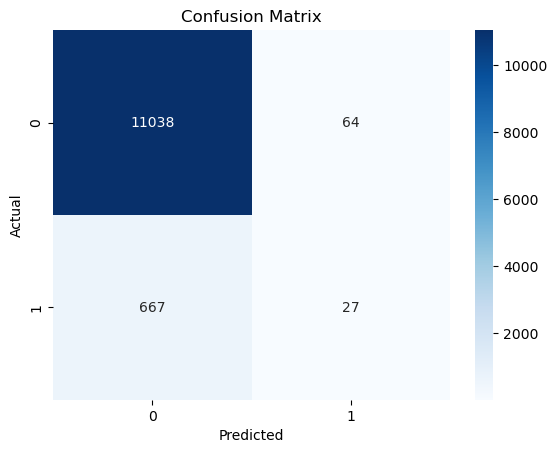

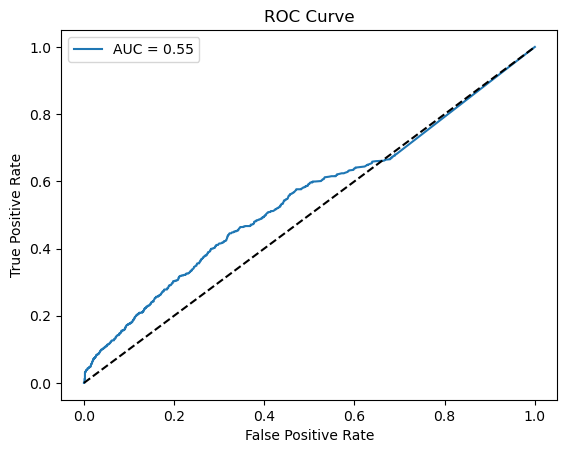

Feature Importance:
       Feature  Importance
0         AGE    0.614487
2  DIAG_COUNT    0.380858
1      GENDER    0.004654


In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("Feature Importance:\n", feature_importance)

## Step 4: Train a XGBoost Model
We'll use a XGBoost Classifier, a robust ML model that handles tabular data well.

In [8]:
import xgboost as xgb
# Initialize and train the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probability of readmission

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc)

AUC Score: 0.6318200448863744


## Step 5: Evaluate and Visualize Results from XGBoost
We'll evaluate the model with a confusion matrix and ROC curve to understand its performance.

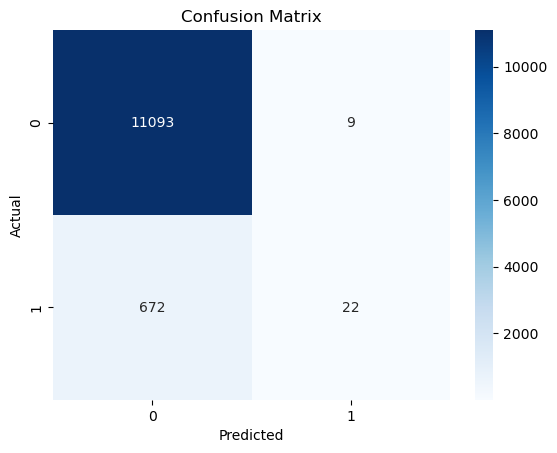

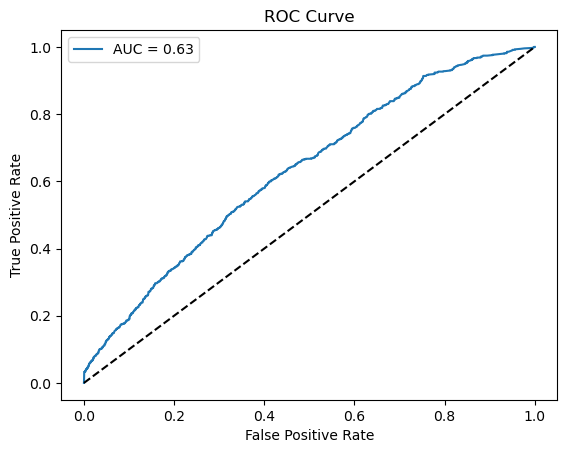

Feature Importance:
       Feature  Importance
2  DIAG_COUNT    0.451963
0         AGE    0.302170
1      GENDER    0.245868


In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("Feature Importance:\n", feature_importance)

## Conclusion
This tutorial showed how to:
1. Load and preprocess MIMIC-III data.
2. Engineer features for readmission prediction.
3. Train and evaluate a Random Forest and XGBoost model.
4. Visualize results with a confusion matrix and ROC curve.

You can extend this by adding more features (e.g., lab results, procedures) or trying other models (e.g. neural networks). 